In [1]:
from scipy import ndimage
from datetime import timedelta
import math
import numpy as np
import random
import time
#from PIL import Image
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
img_size = 128                             # Size of images in testing and training sets
img_size_flat = img_size * img_size        # Size of an array of images pixels (flattened image)
img_shape = (img_size, img_size)           # Tuple to carry the shape of image, so that we could restore the result
                                           # of flattening
num_channels = 1                           # Grayscale is only 1 channel
num_classes = 2                            # Building or non-building

In [3]:
# Extracting the set of names of images for training
#filename = 'subimages/subimage'
training_set = []              # Contains names of images

for i in range(1500):
    training_set.append('subimages/subimage'+str(i+1)+'.png')

train_images = []
for filename in training_set:
    image = ndimage.imread(filename)
    #image = ndimage.resize((IMAGE_SIZE,IMAGE_SIZE))
    train_images.append(np.array(image))


train_labels = ([[0,1],[0,1],[0,1],[0,1],[0,1]]*(300)) # array of all training labels
train_labels = np.array(train_labels)
train_images = np.array(train_images)
train_images = train_images.reshape(-1,img_size_flat) # array of all training images

In [4]:
train_labels.shape

(1500, 2)

In [5]:
# Extracting the set of names of images for testing
#filename = 'subimages/subimage'
test_set = []                  #contains names of images
#for i in range(1,33):
    #test_set.append('TestingSet/testobject_'+str(i+1)+'.png')

test_set = []                  #contains names of images
for i in range(1501,1701):
    test_set.append('subimages/subimage'+str(i+1)+'.png')

test_images = []
for filename in test_set:
    image = ndimage.imread(filename)
    #image = ndimage.resize((IMAGE_SIZE,IMAGE_SIZE))
    test_images.append((image))



test_labels = np.array([[0,1],[0,1],[0,1],[0,1],[1,0]]*40) # array of all test labels
test_images = np.array(test_images)
test_class_labels = np.array([0,0,1,1,0]*40) # all possible classes of test set,1 = bldg
test_images = test_images.reshape(-1,img_size_flat) # array of all test images



#[0,1] is a building label
#[1,0] is a non-building label

In [8]:
test_labels.shape

(200, 2)

In [9]:
# Convolutional Layer 1.
filter_size1 = 9          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 9          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Convolutional Layer 3.
filter_size3 = 9          # Convolution filters are 5 x 5 pixels.
num_filters3 = 36         # There are 36 of these filters.

# Convolutional Layer 4.
filter_size4 = 9          # Convolution filters are 5 x 5 pixels.
num_filters4 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

Below we construct two helper functions, one for creating new wieghts matrix and another for the biases vector.

In [10]:
def new_weights(shape):
    # Takes shape array, returns matrix of size shape that contains 
    #random variables from truncated normal distribution.
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    # Similarly to a function above, this function returns a vector of size length and 
    # fills it with a constant
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [11]:
#has pooling and ReLU built in. So think of it as one block. 
#usually CNNs have 3 blocks repeated.

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [12]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [13]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 2], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [15]:
layer_conv1, weights_conv1 =  new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [16]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)


In [17]:
layer_conv3, weights_conv3 = new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)



In [18]:
layer_conv4, weights_conv4 = new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)


In [19]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 64, 16) dtype=float32>

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 36) dtype=float32>

In [21]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 36) dtype=float32>

In [22]:
layer_conv4

<tf.Tensor 'Relu_3:0' shape=(?, 8, 8, 36) dtype=float32>

In [23]:
layer_flat, num_features = flatten_layer(layer_conv4)

In [24]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2304) dtype=float32>

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [26]:
layer_fc1

<tf.Tensor 'Relu_4:0' shape=(?, 128) dtype=float32>

In [27]:
layer_fc2

<tf.Tensor 'add_5:0' shape=(?, 2) dtype=float32>

In [28]:
y_pred = tf.nn.softmax(layer_fc2)

In [29]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


In [31]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [32]:
y_true

<tf.Tensor 'y_true:0' shape=(?, 2) dtype=float32>

In [33]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [34]:
session = tf.Session()


In [35]:
session.run(tf.global_variables_initializer())


In [36]:
train_batch_size = 20

In [37]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations,images,labels):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        
        x_batch = images[:train_batch_size]
        train_images = images[train_batch_size:]
        y_true_batch = labels[:train_batch_size]
        train_labels = labels[train_batch_size:]

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 2 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [38]:
# Split the test-set into smaller batches of this size.
test_batch_size = 20

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    # Number of images in the test-set.
    num_test = len(test_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0
    start_time = time.time()
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = test_images[i:j, :]

        # Get the associated labels.
        labels = test_labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = test_class_labels

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = sum(correct)

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    
    end_time = time.time()
    time_dif = end_time - start_time
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [39]:
print_test_accuracy()

Accuracy on Test-Set: 49.5% (99 / 200)
Time usage: 0:00:06


In [40]:
optimize(1, train_images, train_labels)
print_test_accuracy()

Optimization Iteration:      1, Training Accuracy: 100.0%
Time usage: 0:00:03
Accuracy on Test-Set: 40.0% (80 / 200)
Time usage: 0:00:07


In [ ]:
optimize(10, train_images, train_labels)
print_test_accuracy()

In [ ]:
optimize(20, train_images, train_labels)
print_test_accuracy()

In [41]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [42]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

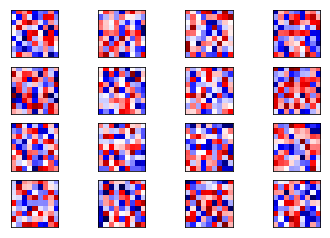

In [43]:
plot_conv_weights(weights=weights_conv1)

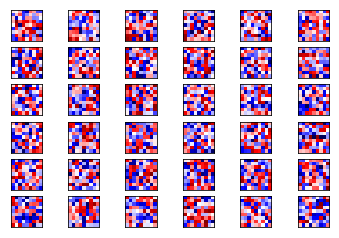

In [44]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

In [ ]:
plot_conv_weights(weights=weights_conv3)

In [ ]:
plot_conv_weights(weights=weights_conv4)

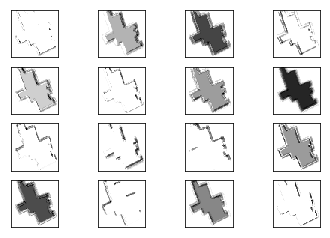

In [48]:
image1 = train_images[59]
plot_conv_layer(layer=layer_conv1, image=image1)